In [1]:
from IPython.display import clear_output

import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import emcee
import arviz as az
from getdist import MCSamples
from getdist import plots as gdplot

In [2]:
## Load data
c = 299792458 # m/s
sn_data = pd.read_csv("sn_data/sn_data.csv")
sn_inv_cov = np.load("sn_data/sn_inv_cov.npy")[np.ix_(sn_data.index, sn_data.index)]

DATA = {
    "Riess2020": {"H0": 73.04, "sigma": 1.04},
    "sn": {"z": sn_data["zHD"].to_numpy(), "MU": sn_data["MU"].to_numpy(), "inv_cov": sn_inv_cov}
}

# Posterior estimation

Last lecture we talked about Bayesian inference and one of the goals is to estimate the posterior. We had a simple analytical example with the dices. If the model, we are interested in, gets any more complicated (Likelihood is not analytically calculable anymore), then analytical approach is not feasible anymore. 

Next logical approach would be to then estimate posterior at different points in the parameters' ($\theta$) space. This approach turns out not computationally possible quite fastas we meet the "**_Curse of dimensionality_**". 

Let's say we have a model of 2 free parameters. To sample the posterior quite well (of course depends a lot on the ) we need maybe 50 points per dimension. This means $50^2 = 2500$ points in total. But usually cosmological models have more free parameters $(h, \Omega_m, \Omega_c, \tau, n_s, A_s, \rm etc.)$. We see that for 5 parameter models we already have $50^5 = 312\ 500\ 000$ points, because of the exponential growth. So usually, using the grid approach becomes unfeasible very fast.

To overcome computational problems **Markov chain Monte Carlo** (MCMC) method was developed. This algorithm uses clever but simple way to draw samples from a probability distribution (in our case posterior).

## Supernovae measurements

For Supernovae measurements we need to know how to calculate luminosity distance
\begin{equation*}
    D_L = (1+z) D_M\,, \tag{1}
\end{equation*}
where $D_M$ is transverse comoving distance
\begin{equation*}
    D_M = D_H \int \limits_{0}^{z} \frac{dz'}{E(z')} = \frac{c}{H_0} \int \limits_{0}^{z} \frac{dz'}{E(z')}\,, \tag{2}
\end{equation*}
assuming flat space and 

\begin{equation*}
    E(z) = \sqrt{\Omega_m(1+z)^3 + \Omega_\Lambda}\,,\quad \Omega_m + \Omega_\Lambda = 1\,. \tag{3}
\end{equation*}


Luminosity distance is related to the apparent magnitude $m$ which we can measure and absolute magnitude $M$, which we don't know

\begin{equation}
 m = M + 5\log_{10}\left(\frac{D_L}{10 \text{pc}}\right) = 25 + M + 5\log_{10}\left(\frac{D_L}{\text{Mpc}}\right) \tag{4}
\end{equation}
This relation shows, that the magnitude we see is dependent on two factors: how bright the star is and how far away from us it is. The problem is, that if we don't know the distance to the star, we can't distinguish $M$ from $D_L$. Rephrasing the equation we get 
\begin{equation}
    m = M + 5\log_{10}\left(\frac{D_H}{1 \text{Mpc}}\right) + 5\log_{10}\left((1+z)\int \limits_{0}^{z} \frac{dz'}{E(z')}\right) \,. \tag{5}
\end{equation}
We could now separate three different variables:
 1) $M$ - absolute magnitude
 2) $5\log_{10}(\frac{D_H}{1 \text{Mpc}})$ - Hubble distance, depends only on $H_0$
 3) $5\log_{10}\left(\int \limits_{0}^{z} \frac{dz'}{E(z')}\right)$ - Depends on $z$ and our cosmological model E(z)

This is good, as in addition to $m$ we can also measure redshift using spectroscopy. So in the end for each supernova we have $(z, m)$ pair.

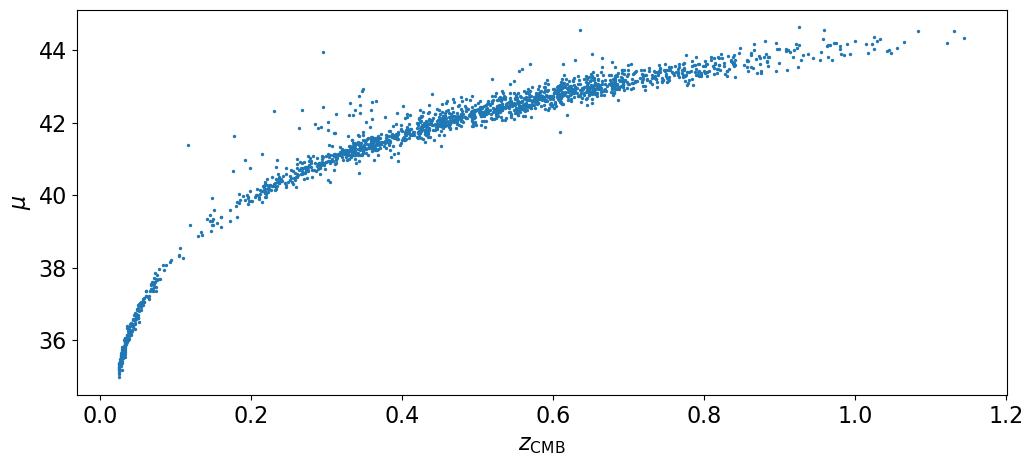

In [3]:
with plt.rc_context({"font.size": 16}):
    plt.figure(figsize=(12, 5))
    plt.scatter(sn_data["zHD"], sn_data["MU"], s=2)
    plt.xlabel(r"$z_{\text{CMB}}$")
    plt.ylabel("$\mu$")
    plt.show()

### Distance modulus $\mu$

DES-Y5 datasets gives values for $(z, \mu)$ pairs, where $\mu$ is distance modulus 
$$\mu = m - M\,. \tag{6}$$

### Bayesian inference

So to compare with the theory we have to calculate $\mu$ from theory
\begin{equation}
 \mu = 5\log_{10}\left(\frac{D_H}{1 \text{Mpc}}\right) + 5\log_{10}\left((1+z)\int \limits_{0}^{z} \frac{dz'}{E(z')}\right) \tag{7}
\end{equation}

To overcome this problem in Bayesian inference we can use marginalisation, which we talked about last lecture. As $M$ and $H_0$ are degenerate it is common to define new parameter $\mathcal{M} = M + 5\log_{10}\left(\frac{D_H}{1 \text{Mpc}}\right)$ and marginalise over $\mathcal{M}$. [More detailed explanation](https://arxiv.org/pdf/astro-ph/0104009) in A.7 - A.12. This can be done analytically, if we assume uniform prior.

We have our difference between theory and observation
\begin{equation}
    \mathbf{y} = (\mu(\theta, \mathcal{M}, z_i) - \mu_{\text{obs}})\tag{8}
\end{equation}
and chi-square
\begin{equation}
    \hat{\chi}^2 =  \mathbf{y}^T \Sigma^{-1} \mathbf{y} \tag{9}
\end{equation}

where $\Sigma^{-1}$ is inverse of covariance structure. In case of uncorrelated data this simply is:
\begin{equation}
    \hat{\chi}^2 = \sum_{i=1}^{n}   y_i^2/\sigma_i^2\,.\tag{10}
\end{equation}

To marginalize over $\mathcal{M}$ assuming uniform prior we get chi-squared to be

\begin{equation}
    \tilde{\chi}^2 = -2\log\left(\int_{-\infty}^{\infty} d\mathcal{M}\exp\left(-\frac{1}{2} \chi^2\right)\right) = \hat{\chi}^2 - \frac{B^2}{C} + \log\left(\frac{C}{2\pi}\right) \tag{11}
\end{equation}

where $\chi^2$ is chi-squared before marginalization (NB! not to mistake with $\tilde{\chi}^2$)

\begin{equation}
    \begin{split}
       B & = \sum_{i=1}^{n} (y^T \Sigma^{-1})_i\\
       C & = \sum_{i=1}^{n}\sum_{j=1}^{n} \Sigma^{-1}_{ij}
    \end{split}  \tag{12}
\end{equation}

## Posterior estimation

For example we can do posterior estimation for DES-Y5 Dovkie dataset. More details about the analyses can be found on the [article](https://arxiv.org/pdf/2511.07517).

In our current example the chosen likelihood is multivariate Gaussian

\begin{equation}
    \mathcal{L}_{\rm DESY5}(\theta) = \frac{1}{(2\pi)^{k/2} |\Sigma|^{1/2}} \exp\left[-\frac{1}{2}(\mathbf{d}-M(\theta))^T\Sigma^{-1}(\mathbf{d}-M(\theta))\right]\tag{13}
\end{equation}

where the variables represent following quantities:
 * $M(\theta)$ is the model prediction, given our model parameters $\theta$
 * $\mathbf{d}$ is k-dimensional data vector
 * $\Sigma$ is $k \times k$ covariance matrix for the data. If data points are not correlated, this is just a diagonal matrix.

To break the degeneracy between $H_0$ and $M$ we introduce $H_0$ measurement, from SH0ES experiment
\begin{equation}
    \mathcal{L}_{\rm RIESS 2020}(\theta) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp\left[-\frac{[\mathbf{d}-M(\theta)]^2}{2\sigma^2}\right]\tag{14}
\end{equation}
Where $d=73.04$ and $\sigma = 1.04$. Results from [https://arxiv.org/pdf/2112.04510](https://arxiv.org/pdf/2112.04510).

So total likelihood is
\begin{equation}
 \mathcal{L}(\theta) = \mathcal{L}_{\rm DESY5}(\theta) \times \mathcal{L}_{\rm RIESS 2020}(\theta) \tag{15}
\end{equation}


### Analytical

In [4]:
def calculate_luminosity_distances(z_values, H0, Omega_m):
    z_values = np.array(z_values)
    z_array = np.unique(np.copy(z_values))
    dL = np.array(sc.integrate.solve_ivp(lambda z, y: 1/np.sqrt(Omega_m*(1+z)**3 + (1-Omega_m)), t_span=[0, max(z_array)], y0=[0.0], method="RK45", t_eval=z_array).y).flatten()*(1+z_array)
    z_dL = dict(zip(z_array, dL))
    dL_values = c/1000/H0 * np.array([z_dL[z] for z in z_values])
    return dL_values

In [5]:
def logL_supernovae(theta, data):
    # H0 in units of km/s/Mpc
    H0, Omega_m = theta
    
    z_obs = data["sn"]["z"]
    mu_obs = data["sn"]["MU"]
    inv_cov = data["sn"]["inv_cov"]
    
    # Marginalize over $\mathcal{M}$
    delta = 5*np.log10(calculate_luminosity_distances(z_obs, H0, Omega_m)) + 25 - mu_obs
    A = delta.T @ inv_cov @ delta
    B = np.sum(inv_cov @ delta)
    C = np.sum(inv_cov)
    chi2 = A - B**2/C
    return -0.5 * chi2

def logL_H0(theta, data):
    H0, Omega_m = theta
    return -0.5 * (data["Riess2020"]["H0"]-H0)**2/data["Riess2020"]["sigma"]**2

def logL(theta, data):
    total_logL = logL_supernovae(theta, data)
    total_logL += logL_H0(theta, data) # If you comment this out, then sensitivty to H_0 is lost
    return total_logL

### Lattice

In [58]:
def calculate_L_grid(H0_range, N_H0, Omega_m_range, N_Omega_m):
    H0_values = np.linspace(H0_range[0], H0_range[1], N_H0)
    Omega_m_values = np.linspace(Omega_m_range[0], Omega_m_range[1], N_Omega_m)
    X, Y = np.meshgrid(H0_values, Omega_m_values)
    logL_values = np.array([[logL([_H0, _Omega_m], DATA) for _H0 in H0_values] for _Omega_m in Omega_m_values]).reshape(N_Omega_m, N_H0)
    L_likelihood_rescaled = np.exp(logL_values-np.max(logL_values))
    return H0_values, Omega_m_values, L_likelihood_rescaled, X, Y

In [7]:
def make_triangle_plot(H0_values, Omega_m_values, H0_grid, Omega_m_grid, posterior_samples_on_grid):
    with plt.rc_context({"font.size": 13}):
    
        fig, axes = plt.subplots(2, 2, figsize=(11, 8))
        axes[0, 1].axis('off')
        axes[0, 0].plot(H0_values, np.sum(posterior_samples_on_grid, axis=0))
        axes[1, 1].plot(Omega_m_values, np.sum(posterior_samples_on_grid, axis=1))
        c = axes[1, 0].contourf(H0_values, Omega_m_values, posterior_samples_on_grid, levels=[1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
                                norm=mpl.colors.LogNorm(vmin=1e-6, vmax=1), extend="min")
        cbar = plt.colorbar(c, ax=axes[1, 0])
        axes[1, 0].scatter(H0_grid, Omega_m_grid, color="black", s=0.5)
        axes[1, 0].set_xlabel(r"$H_0$")
        axes[1, 0].set_ylabel(r"$\Omega_m$")
        axes[1, 1].set_xlabel(r"$\Omega_m$")
        plt.show()

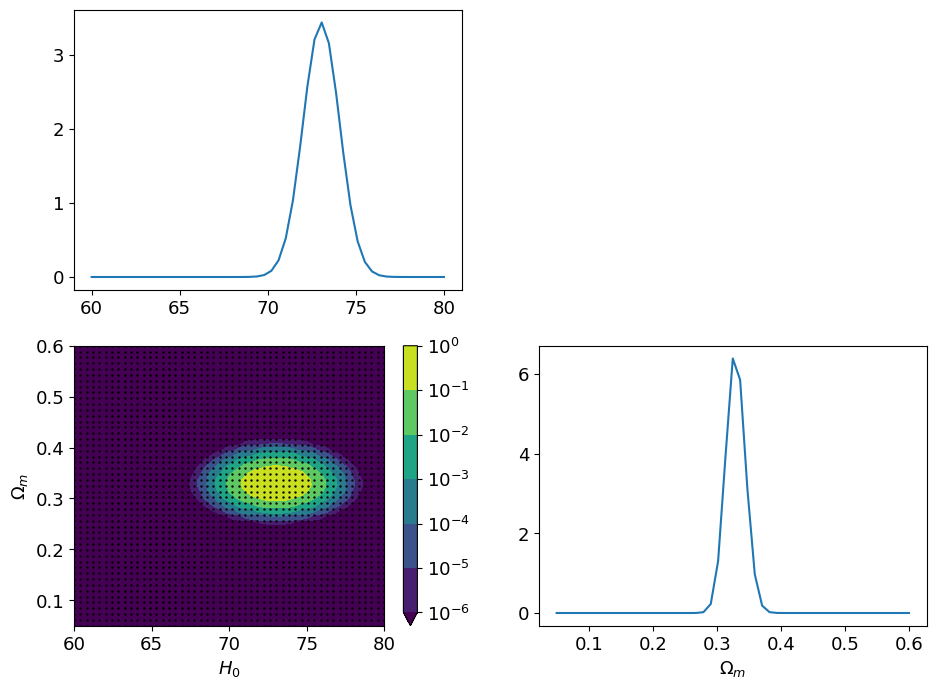

In [60]:
H0_values, Omega_m_values, L_likelihood_rescaled, X, Y = calculate_L_grid([60, 80], 50, [0.05, 0.6], 49)
make_triangle_plot(H0_values, Omega_m_values, X.flatten(), Y.flatten(), L_likelihood_rescaled)

This approach is very unefficient. First we if we make the grid too big, then not many points cover the interesting region. Also, if the resolution is too big, then it is hard to find the interesting region. In the end we probably would have to repeat the grid calculation with better resolution in the interesting region.  

In [9]:
print(f"ΔlogL>=13.816: {float(np.sum(L_likelihood_rescaled > np.exp(-13.815510557964274))/L_likelihood_rescaled.size)*100:.2f}% of samples.")

ΔlogL>=13.816: 12.08% of samples.


### MCMC

The main aim of the MCMC algorithm is to sample probability distributions.

#### **Monte Carlo**

Monte Carlo is class of algorithms which is based on repeated random sampling. One simple example is calculating the $\pi$. We draw N indepentent samples in a unit box. The probability of point being in a circle is $p=\frac{\pi}{4}$. So if we have $N$ samples then on average we have $N \frac{\pi}{4}$ samples inside the circle. So the result will be $$\pi \approx 4 \frac{N({\text{points inside the circle})}}{N}\,.\tag{16}$$

Most common use cases for Monte Carlo method is to:
 * Optimization
 * Numerical integration
 * Drawing samples from probability distribution (our use case)


In [10]:
def monte_carlo_example(n_samples):
    with plt.rc_context({"font.size": 15}):

        fig= plt.figure(figsize=(13, 6))
        ax1 = plt.subplot2grid((2, 2), (0, 0), rowspan=2)  # row 0, col 0
        ax1.set_xlim(-0.5, 0.5)
        ax1.set_ylim(-0.5, 0.5)
        r_circle = 0.5
        
        theta = np.linspace(0, 2*np.pi, 1000)
        ax1.plot(r_circle*np.cos(theta), r_circle*np.sin(theta), color="red")
        # Sample N points uniformly in a box
        x = np.random.uniform(-0.5, 0.5, n_samples)
        y = np.random.uniform(-0.5, 0.5, n_samples)
        # Calculate radius and count how many are inside the circle
        r = np.sqrt(x**2 + y**2)
        n_points_inside_circle = np.sum(r<=r_circle)
        n_points_inside_circle_by_step = np.cumsum(r<=r_circle)
        n_total_points_by_step = np.arange(1, n_samples+1)
        ax2 = plt.subplot2grid((2, 2), (0, 1))  # row 0, col 1
        ax2.plot(n_total_points_by_step, 4*n_points_inside_circle_by_step/n_total_points_by_step)
        ax2.set_xlabel("N")
        ax2.set_ylabel("$\\pi$")
        ax2.axhline(np.pi, color="red", linestyle="--")
        
        ax3 = plt.subplot2grid((2, 2), (1, 1))  # row 1, col 1
        ax3.plot(n_total_points_by_step, n_points_inside_circle_by_step/n_total_points_by_step)
        ax3.set_xlabel("N")
        ax3.set_ylabel("$A$")
        ax3.axhline(np.pi*0.5**2, color="red", linestyle="--")
        
        if n_samples > 1000:
            ax2.set_xscale("log")
            ax3.set_xscale("log")
        
        area_of_rectangle = 1
        ax1.scatter(x, y, s=2)
        pi_value = 4 * (n_points_inside_circle/n_samples)
        # Calculate pi and the Area
        ax1.set_title(f"$\pi={pi_value:.3f} \\pm {2/np.sqrt(n_samples):.3f}\ (true: {np.pi:.5f})$\n$A={area_of_rectangle*n_points_inside_circle/n_samples:.5f} \\pm {1/np.sqrt(n_samples)}\ (true: {np.pi*0.5**2:.5f})$")
        #print(f"π = {pi_value:.5f} ± {2/np.sqrt(n_samples)} (true: {np.pi:.5f})")
        #print(f"A = {area_of_rectangle*n_points_inside_circle/n_samples:.5f} ± {1/np.sqrt(n_samples)} (true: {np.pi*0.5**2:.5f})")
        fig.tight_layout()
        plt.show()

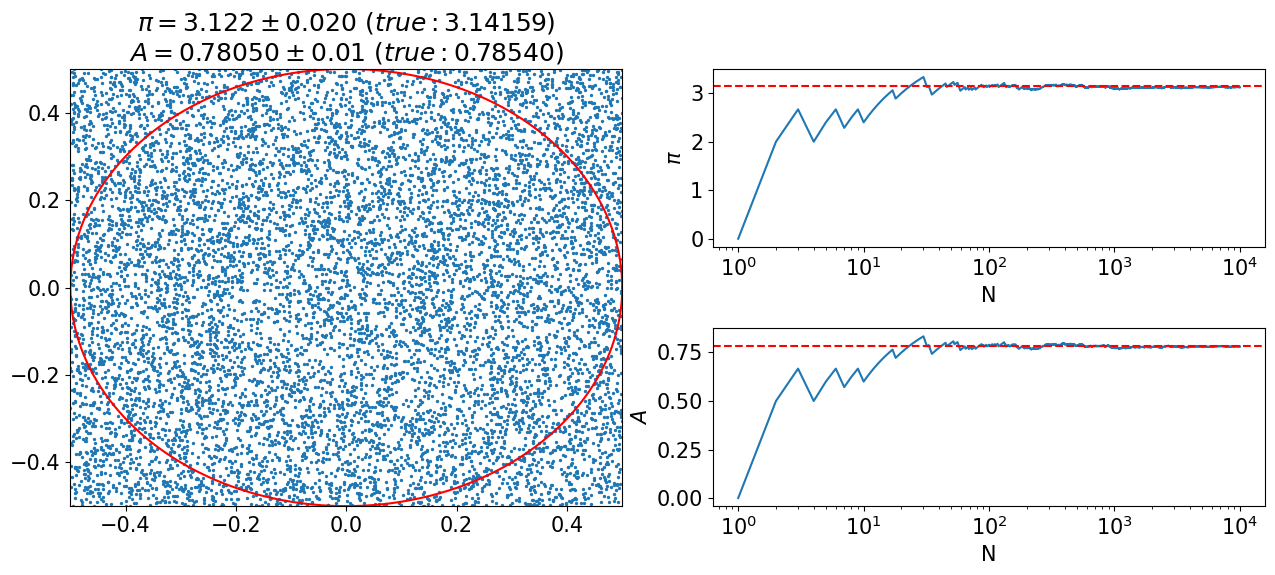

In [11]:
monte_carlo_example(10_000)

#### Markov chain

Markov chain/process is a term used in probability theory for a stochastic process where the outcome of each event depends on the current state.
<figure  style="text-align: center;">
  <img src="images/MarkovChain.svg" alt="Example of a Markov chain" style="width: 50%; height: auto;">
  <figcaption>Example of a Markov chain</figcaption>
</figure>

#### Markov Chain Monte Carlo

Now combining these two methods we get the Markov Chain Monte Carlo. In this algorithm we construct a Markov Chain(s), a series of samples, where the next step depends only on the current state (parameter values). Selection of a next step is random (Monte Carlo) but adhers to some defined **transition rule**. On this lecture we do an example of Metropolis-Hastings (later use better sampler), but there are also other common ones like: Gibbs sampling and Hamiltonian Monte Carlo. 

#### Metropolis-Hastings

One of the most famous MCMC variations is Metropolis-Hasrings. The logic of the algorithm is following (transition rule):
1. Pick a initial value(s) $\theta$ and evaluate it. This is the start of the Markov chain.
2. Pick a new $\theta'$ from the proposal pdf (dependent on $\theta_0$).
3. Generate random number $p$ between [0, 1].
   - a) If $\frac{f(\theta')}{f(\theta)} > p$ then accept the step and add it to chain. Update the $\theta = \theta'$ and repeat the process from 2)
   - b) If the ratio is smaller, then go back to process 2) but don't update the $\theta$

We can express the acceptance probability as:

\begin{equation}
  P(\theta \rightarrow \theta') = \min\left(1, \frac{\mathcal{L}(\theta')\pi(\theta')}{\mathcal{L}(\theta)\pi(\theta)}\right)\,. \tag{17}
\end{equation}

There is three remarks to be made:
1)  proposal pdf is a distribution from which we generate our next sample $\theta'$. Very commonly it is selected to be a Gaussian centered on the current parameter value $\theta$
$$\text{pdf} \propto \exp\left(\frac{(\theta - \theta')^2}{\sigma^2}\right)\,. \tag{18}$$
2) $f(\theta) \propto P(\theta | d)$ must be proportional to posterior. Usually this is only Likelihood times prior $\mathcal{L}(d|\theta) \times \pi(\theta)$ as evidence $P(d)$ is constant and unknown.
3) Likelihoods can be very small numbers, so it is more convenient to deal with log-likelihoods. This means multiplications are replaced by sums.

In [12]:
class MetropolisHastings:
    def __init__(self, f_logpdf, theta0, proposal_scale, *args):
        self.f_logpdf = f_logpdf
        # Let's define our chain and first value in the chain
        self.current_step = np.array(theta0)
        self.chains = np.array(theta0).reshape(-1, 1)
        self.current_step_value = f_logpdf(theta0, *args)
        # Define Gaussian (proposal pdf) variance 
        self.proposal_scale = proposal_scale
        # Arguments for log-posterior function
        self.args = args

    def step(self):
        new_step = np.random.normal(self.current_step, self.proposal_scale)
        new_step_value = self.f_logpdf(new_step, *self.args)
        
        metadata = {"old_step": self.current_step, "old_step_value": self.current_step_value, "new_step": new_step, "new_step_value": new_step_value, "logp": None}

        if new_step_value > self.current_step_value:
            # If new likelihood (log-likelihood) is better then current, then accept always 
            self.chains = np.vstack([self.chains, new_step])
            self.current_step_value = new_step_value
            self.current_step = new_step
            return True, metadata
        else:
            # If new likelihood (log-likelihood) is worse then current, then accept with probability 
            # determined by the ratio of the posteriors
            log_of_ratio = new_step_value - self.current_step_value
            logp = np.log(np.random.uniform(0, 1))
            metadata["logp"] = logp
            
            if log_of_ratio > logp: # Accept the new result
                self.chains = np.vstack([self.chains, new_step])
                self.current_step_value = new_step_value
                self.current_step = new_step
                return True, metadata
            
            return False, metadata
    
    def sample(self, n_steps):
        accepted_count = 0
        while accepted_count < n_steps:
            accepted, _ = self.step()
            if accepted: accepted_count+=1

In [16]:
def f_loggaussian(x, mean, std):
    return -0.5*(x-mean)**2/std**2 # We can ignore constants 
def f_gaussian(x, mean, std):
    return np.exp(-0.5*(x-mean)**2/std**2)/np.sqrt(2*std**2*np.pi)

In [17]:
EXAMPLE_MEAN = 5
EXAMPLE_STD = 10

#### Example - single step

In [18]:
MCMC_example_step = MetropolisHastings(f_loggaussian, 0.1, 10, EXAMPLE_MEAN, EXAMPLE_STD)
EXAMPLE_CHAIN = [0.1]
LAST_METADATA = None
BINS = np.linspace(EXAMPLE_MEAN-3*EXAMPLE_STD, EXAMPLE_MEAN+3*EXAMPLE_STD, 61)
BIN_WIDTH = 6*EXAMPLE_STD/60

In [19]:
def do_N_steps(n_steps, sampler, chain):
    for i in range(n_steps):
        _accepted, _metadata = sampler.step()
        if _accepted: chain.append(_metadata["new_step"])
    return _accepted, _metadata

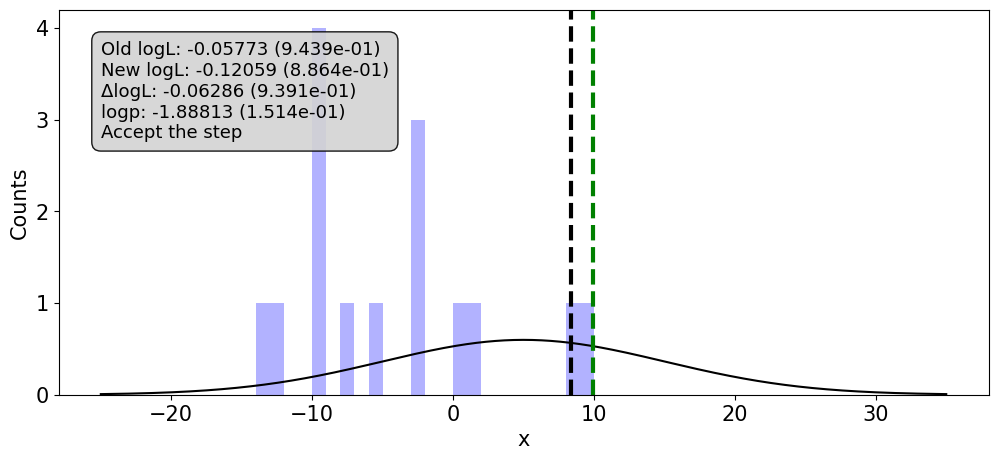

In [20]:
with plt.rc_context({"font.size": 15}):
    clear_output(wait=True)
    fig, ax = plt.subplots(ncols=1, figsize=(12, 5))
    _accepted, _metadata = do_N_steps(20, MCMC_example_step ,EXAMPLE_CHAIN)
    _scale =  len(EXAMPLE_CHAIN) * BIN_WIDTH 
    x_vals = np.linspace(EXAMPLE_MEAN-3*EXAMPLE_STD, EXAMPLE_MEAN+3*EXAMPLE_STD, 1000)
    
    hist = ax.hist(EXAMPLE_CHAIN, bins=BINS, color="blue", alpha=0.3);
    ax.plot(x_vals, f_gaussian(x_vals, EXAMPLE_MEAN, EXAMPLE_STD)*_scale, color="black")
    ax.axvline(_metadata["old_step"], color="black", linestyle="--", linewidth=3)
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    if _accepted:
        ax.axvline(_metadata["new_step"], color="green", linestyle="--", linewidth=3)
    else:
        ax.axvline(_metadata["new_step"], color="red", linestyle="--", linewidth=3)
    _string = f"Old logL: {_metadata['old_step_value']:.5f} ({np.exp(_metadata['old_step_value']):.3e})\nNew logL: {_metadata['new_step_value']:.5f} ({np.exp(_metadata['new_step_value']):.3e})\n"
    _string += f"ΔlogL: {_metadata['new_step_value']-_metadata['old_step_value']:.5f} ({np.exp(_metadata['new_step_value']-_metadata['old_step_value']):.3e})\n"
    _string += f"logp: -\n" if _metadata["logp"] is None else f"logp: {_metadata['logp']:.5f} ({np.exp(_metadata['logp']):.3e})\n"
    _string += "Accept the step" if _accepted else "Reject the step"
    ax.text(EXAMPLE_MEAN-3*EXAMPLE_STD, max(hist[0])*0.70, s=_string,             bbox=dict(facecolor="lightgrey", alpha=0.9, edgecolor='black', boxstyle="round,pad=0.5"), fontsize=13) 
    plt.ylabel("Counts")
    plt.xlabel("x")
    plt.show()


#### Example - full result

You can try and test different initial values and proposal scales.

You should see two scenarios:
 * If the proposal scale is too high, then a lot of samples get rejected, as proposed samples are far away from current sample. This leads to low acceptance rate and longer computational time.
 * If the proposal scale is too small, then autocorrelation between samples is high and poor mixing. This means that the chain moves very slowly thorugh the parameters space. To explore the distribution properly takes a lot time.

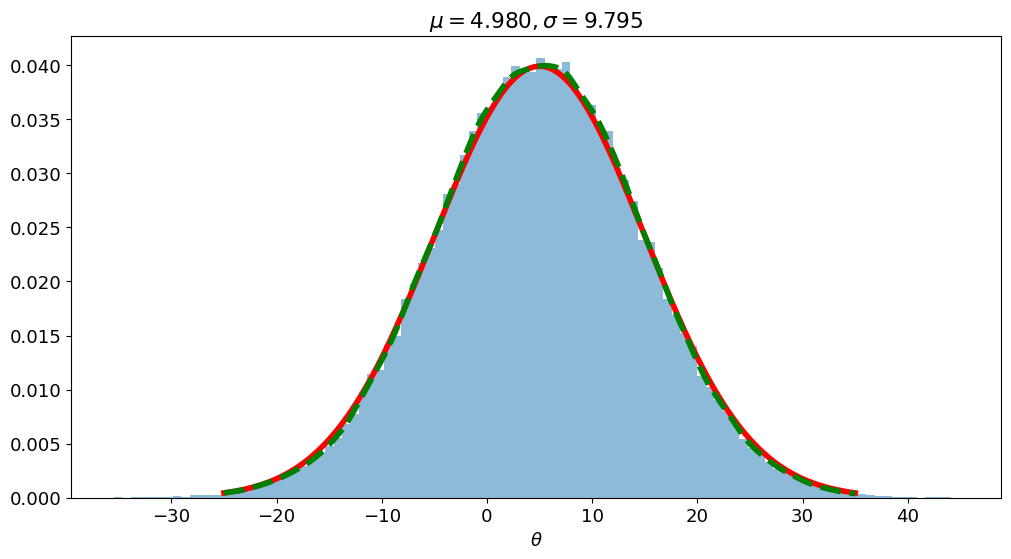

In [21]:

EXAMPLE_MEAN = 5
EXAMPLE_STD = 10
MCMC_example = MetropolisHastings(f_loggaussian, -10, 10, EXAMPLE_MEAN, EXAMPLE_STD)
MCMC_example.sample(100_000)
with plt.rc_context({"font.size": 13}):
    plt.figure(figsize=(12, 6))
    plt.hist(MCMC_example.chains.flatten(), bins=100, density=True, alpha=0.5)
    x_vals = np.linspace(EXAMPLE_MEAN-3*EXAMPLE_STD, EXAMPLE_MEAN+3*EXAMPLE_STD, 1000)
    y_vals = f_gaussian(np.linspace(EXAMPLE_MEAN-3*EXAMPLE_STD, EXAMPLE_MEAN+3*EXAMPLE_STD, 1000), EXAMPLE_MEAN, EXAMPLE_STD)
    plt.plot(x_vals, y_vals, linewidth=4, color="red")
    
    kdee = sc.stats.gaussian_kde(MCMC_example.chains.flatten())
    plt.plot(x_vals, kdee(x_vals), color="green", linestyle="--", linewidth=4)
    # plt.hist(MCMC_example.chains, bins=100)
    plt.title(f"$\\mu={np.mean(MCMC_example.chains):.3f}, \\sigma={np.std(MCMC_example.chains):.3f}$")
    plt.xlabel("$\\theta$")
    plt.show()

#### Example: Supernovae

Usually it is beneficial to use already written MCMC samplers, which are usually more optimized or faster. In this example we use Python package ``emcee``, which uses Affine Invariant Markov chain Monte Carlo (MCMC) sampler. This sample is unaffected by affine transformation of space, making it more robust to highly skewed distributions.

In [22]:
def log_prior_emcee(theta):
    H0, Omega_m = theta
    if 60 < H0 < 80 and 0.05 < Omega_m < 0.5:
        return 0  # Flat prior (no penalty) for H0 and Omega_m within range
    return -np.inf  # Log of zero if outside prior bounds

def log_posterior(theta, data):
    lp = log_prior_emcee(theta)
    if not np.isfinite(lp):  # If the prior is zero, return zero log-posterior
        return -np.inf
    return lp + logL(theta, data)  # Add log-likelihood to log-prior


In [81]:
nwalkers = 4
# Number of dimensions (parameters you want to sample)
ndim = 2  # For H0 and Omega_m
# Initial position of walkers (random starting points in parameter space)
p0 = np.random.rand(nwalkers, ndim)  # Random starting points in the range [0, 1]

# Rescale the initial positions to a reasonable range
p0[:, 0] = p0[:, 0] * (80 - 60) + 60  # H0 range [60, 80]
p0[:, 1] = p0[:, 1] * (0.6 - 0.05)  # Omega_m range [0, 1]

# Set up the `emcee` sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[DATA])

# Run the MCMC chain (1000 steps as an example)
# Burn-in period: discard the first few steps (e.g., 500 steps)
burn_in_steps = 500
sampling_steps = 1500

# Run the chain
sampler.run_mcmc(p0, burn_in_steps + sampling_steps, progress=True);

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:43<00:00, 45.86it/s]


In [84]:
raw_chains = chains = sampler.get_chain() 
chains = sampler.get_chain(discard=500)  # Shape: (nsteps, nwalkers, ndim)
log_prob = sampler.get_log_prob(discard=500)  # Shape: (nsteps, nwalkers)

# Convert to MCSamples using multiple chains
# Each emcee walker should be treated as a separate chain
# Convert to list of chains (each walker becomes a chain)
chain_list = [chain[:, i, :] for i in range(chains.shape[1])]  # List of (nsteps, ndim)
logprob_list = [log_prob[:, i] for i in range(log_prob.shape[1])]  # List of (nsteps,)

samples = MCSamples(
    samples=chain_list,  # List of arrays, each walker as separate chain
    loglikes=[-lp for lp in logprob_list],  # List of -log(posterior) arrays
    names=['H0', 'Omega_m'],
    labels=[r'H_0', r'\Omega_m'],
    label='Line Fitting with emcee'
)


Removed no burn in


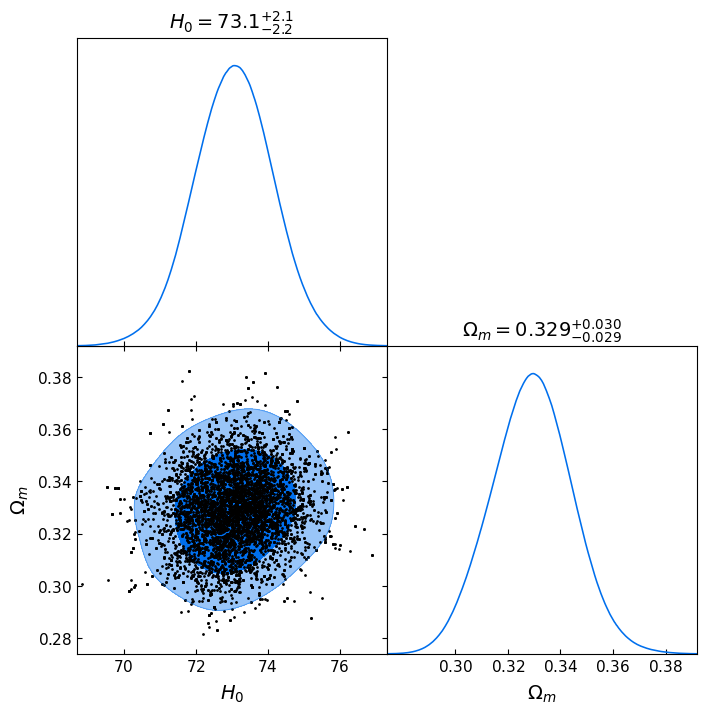

In [85]:
g = gdplot.get_subplot_plotter(subplot_size=4)
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4
g.settings.title_limit_fontsize = 14

g.triangle_plot(
    samples,
    title_limit=2,
    filled=True,
)
g.fig.axes[0].scatter(samples.samples[:, 0], samples.samples[:, 1], color="black", s=1)
plt.show()

In [98]:
def plot_chain_movement(H0_range, N_H0, Omega_m_range, N_Omega_m, chain, n_steps=250):

    H0_values, Omega_m_values, Posterior, _, _ = calculate_L_grid(H0_range, N_H0, Omega_m_range, N_Omega_m)
    with plt.rc_context({"font.size": 16}):

        fig, ax = plt.subplots(figsize=(11, 8))
        c = ax.contourf(H0_values, Omega_m_values, Posterior, levels=[1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
                                    norm=mpl.colors.LogNorm(vmin=1e-6, vmax=1), extend="min", cmap="Reds")
        cbar = plt.colorbar(c, ax=ax, label=r"$\propto$ Posterior")
        ax.plot(chain[:n_steps, 0], chain[:n_steps, 1], color="green")
        plt.title("MCMC walker's random walk")
        plt.show()
    

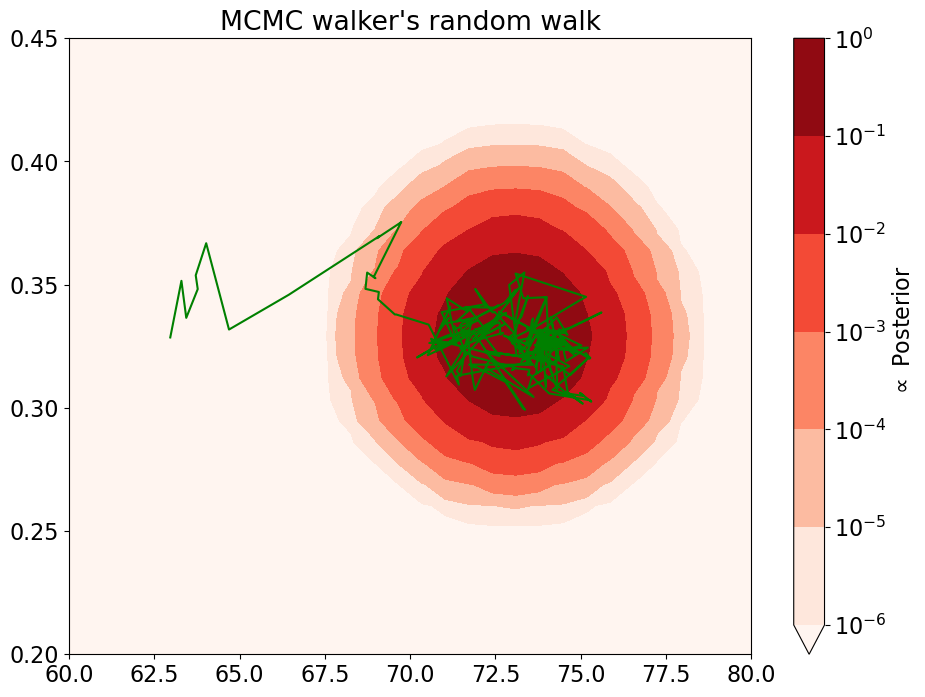

In [101]:
plot_chain_movement([60, 80], 30, [0.2, 0.45], 30, raw_chains[:,0,:], n_steps=500)
#plot_chain_movement([60, 80], 30, [0.2, 0.45], 30, raw_chains[:,1,:], n_steps=500)
#plot_chain_movement([60, 80], 30, [0.2, 0.45], 30, raw_chains[:,2,:], n_steps=500)
#plot_chain_movement([60, 80], 30, [0.2, 0.45], 30, raw_chains[:,3,:], n_steps=500)

##### Marginalization in MCMC

Remember the analytical definition
\begin{equation}
    P(\theta_1, \theta_2 | D) = \int \underbrace{P(\theta_1, \theta_2, \theta_3 | D)}_{\text{Full posterior}} d\theta_3\,. \tag{19}
\end{equation}

To marginalize over chain of parameter $\theta_3$ we just leave out parameter $\theta_3$ from the samples and plot pde without it.

# Extra

## Kernel Density Estimator (KDE)

MCMC result does not give us automatically the probability density function of the posterior (for continous random variable). We need to derive the pde from the MCMC samples. Common approach is to use KDE, which would apply some kernel on top of the data to estimate the density.

The KDE at a point $x$ is
\begin{equation}
    \hat{f}(x) = \frac{1}{nh}\sum_{i=1}^{n}K\left(\frac{x-x_i}{h}\right)\,,\tag{19}
\end{equation}

where $K$ is the Kernel. Often it is used Gaussian function as a kernel:
\begin{equation}
    K\left(\frac{x-x_i}{h}\right) = \frac{1}{\sqrt{2}\pi} \exp\left(-\frac{1}{2}\left(\frac{x-x_i}{h}\right)^2\right)\,.\tag{20}
\end{equation}
